<a href="https://colab.research.google.com/github/sazid22/UTS_ML_ID13383575/blob/master/UTS_ML2019_A2_13383575_13083112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## UTS 32513 Machine Learning
## Assignment 2 - Practical Machine Learning Project
## Title - Fake News Analysis Using Naive Bayes
### Submitted By - 13083112 and 13383575
### Colab Link - https://colab.research.google.com/drive/1W_fn8QSjQK1XT-6Kn1lKY_xp4KWqCEC4
### GitHub Link - https://github.com/sazid22/UTS_ML_ID13383575

## 1.Introduction
Information is available to everyone with the introduction of technology. This is a breakthrough in human history, but at the same point, it obscures the boundary between genuine news and maliciously produced publicity. To filter the data we obtain daily, we need an instrument to check the reliability of the news. With this motive, we have collaborated on our second assessment by constructing a system by our understanding of python and machine learning. Given a news article's content and title as input, we have created a scheme that can contrast between false and real news with 71 percent precision. The inspiration for this project came from a Google Chrome extension named BS Detector which flags fake articles or sarcastic articles on various websites. 

This project consists of numerous binary classification (true/fake) of news. We apply the datasets from Kaggle, All the news by Andrew Thompson and Getting Real about Fake News by Megan Risdal. Here are their links respectively:<br/>
https://www.kaggle.com/snapcrack/all-the-news
<br/>
https://www.kaggle.com/mrisdal/fake-news
<br/><br/>

We use python to create our model. Taking 12999 real news samples and 12999 fake news samples, we do natural language processing using NLP library in python. Having this big dataset, we pre-process the data and classify it using our Naive Bayes classifier. Based on the identification of indicative tokens through Naive Bayes, we can calculate the probability given a new which is fake new.

## 2.Exploration
Due to the rise of social media and online news circulation, fake news has been spreading like disease. The challenges we have faced during implementing this project as follows – 
* Huge Amount of Data – As mentioned earlier, in this era of Internet there is lot of articles spreading here and there all over. As a result, the amount of data in enormous just even the text document. So initially we had to decide on what kind of data we wanted to work on. We decided to work on news articles but over 200+ countries in the world and the news articles are published in various languages we finally decided to work with two datasets from Kaggle. These two datasets contain articles from famous news agencies like CNN, BCC, Fox News, Guardian, Washington Post etc. So, scaling down huge amount of data was one of the challenges for this project.
* Word Ambiguity – In the NLP, one of the challenges in NLP field is word ambiguity. In English, some words have several meanings and their meaning in sententce need to be determined by the context of sentence. For instance, the meanings of word 'bank' in 'Water smacked the river banks in large waves from the impact.' and 'Your bank card must be activated before using.' are totally different. Moreover, different tense of a verb is another problem. Suppose there is verb run. And for different context past and past participle of ‘run’ is used in the article as well as there are some verbs whose different tense are represented by same word. So, differentiating this was a challenge. To overcome this, we used lemmatization technique. Lemmatization is the process of grouping different forms of a word so they can be analyzed as a single item.
* Context of Pronoun – As a human we are very intuitive to understand a meaning of a word from the context of the passage even if we do not know the actual meaning of the word. But this is not possible for a model. Model cannot even understand the context of a pronoun meaning if there is a pronoun used in the article “he’, the model cannot understand who has been referred as “he.” So, this was a challenge for the project.
* Stop Words – In any article or even on the news headline there are words like articles, prepositions, conjunctions. These are needed to make sense to reader but for task like fake news analysis these words create complexity. Because as the dataset is big, step like tokenization will take lots of time. So, removing stop words was a challenge. 
* Punctuation Marks – Punctuation marks was one of the challenges for the task. As punctuation does not carry any individual meaning it needs to be removed. Because, suppose there is a word good and in the article, there is “good”. Both might have same meaning, but due to inverted comma, there will be different tokenization which results in different result. So, removing punctuation mark was needed to make the detection more meaningful. The above reasons are the general reasons for punctuation. With these datasets, we encounter some specific problems. Some of news include website addresses and some meanless symbols,such as xdl. The online addresses prevent us directly removing the punctuation, because "www.google.com" will become ["www","google","com"] if we remove the punctuation dot '.'. The meanless symbols cannot be remove beacuse they also consist of letters, so that we apply a naive method via removing the words of which size is less than 3.


# 2.1 Download Dataset

First of all, we download the dataset by uploading them into a shared Google Drive folder. Here is the link of that folder.
<br/>
Dataset folder: https://drive.google.com/open?id=1_MXCAVTBYmF9K8rtxCidNeoCxtgUXxUT

In [0]:
# download dataset from Google drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from pathlib import Path
data_dir=Path("./dataset")
data_dir.mkdir(parents=True, exist_ok=True)
# Download a file based on its file ID.
# share folder: https://drive.google.com/open?id=1_MXCAVTBYmF9K8rtxCidNeoCxtgUXxUT

folder_id = '1_MXCAVTBYmF9K8rtxCidNeoCxtgUXxUT'
file_list = drive.ListFile({'q':"'{}' in parents and trashed=false".format(folder_id)}).GetList()
for i,file in enumerate(file_list,start=1):
  print('Downloading {} from GDrive ({}/{})'.format(file['title'], i, len(file_list)))
  file.GetContentFile(data_dir/file['title'])


Because the dataset of real news has 4 .csv file, we need to combine these 4 tables into 1 array.

In [0]:
# import nlp lib
import spacy
import torch
import numpy as np
import pandas as pd
torch.manual_seed(1234)
nlp=spacy.load('en')
fake_news=pd.read_csv('./dataset/fake.csv', sep=',',header=None).values
real_news=[]
for i in range(1,4) :
  articles=pd.read_csv('./dataset/articles{}.csv'.format(i), sep=',', header=None)
  if i == 1:
    real_news=articles.values
    continue
  real_news = np.concatenate((real_news, articles.values[1:]),axis= 0)
  real_news[0,-1] = 'text' #normalize the column name

In [0]:
# input: a 1*n headers and a m*n data without headers
# output: a table with headers
def add_headers(headers, content):
  return np.concatenate((np.array([headers]),content),axis=0)

# input: a table containing headers and a column name
# output: the index of that column in array
def find_column(arr,col):
  headers = arr[0,:]
  for i,th in enumerate(headers):
    if col==th:
      return i

In [0]:
# input: a numpy format table with headers
def show_table(data):
  length = data.shape[0]
  df = pd.DataFrame(data[1:],columns=data[0]) 
  return df 

The attributes of these two datasets as shown follow:
### Columns of Real News Dataset
|||||||||||
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|kaggle_id|id|title|publication|author|date|year|month|url|content|

### Columns of Fake News Dataset
|||||||||||
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|kaggle_id|uuid|ord_in_thread|author|published|title|text|language|crawled|site_url|
|country|domain_rank|thread_title|spam_score|main_img_url|replies_count|participants_count|likes|comments|shares|type|

As shown above, these two datasets have different columns ,different headers and even different format of data. Moreover, there are different languages of news in fake news dataset. For convenient, we just choose the headline and content of news by English and combine these two columns as a feature used in following processing. Afterwards, we will assign a label of 0 or 1 for each news which present fake or real respectively.

In [0]:
#For convient, throw the extra information: non-english new, extra column
fi_language = find_column(fake_news, "language") # fake_index_language
fi_title = find_column(fake_news, "title")
fi_text = find_column(fake_news, "text")

fake_data =add_headers(fake_news[0], np.array([row for row in fake_news[1:] if row[fi_language]=="english"]))
fake_data = fake_data[:,[fi_title,fi_text]]
label_column = np.array([np.zeros(fake_data.shape[0])]) #assign a label column consist of 0
label_column = label_column.reshape([fake_data.shape[0],1])
label_column = add_headers(np.array(['label']),label_column[:-1])
fake_data = np.concatenate((fake_data,label_column),axis=1)

ri_title = find_column(real_news, "title")
ri_text = find_column(real_news, "text")   
real_data = np.array(real_news[:fake_data.shape[0],[ri_title,ri_text]]) # choose from top 
label_column[1:] = 1
real_data = np.concatenate((real_data,label_column),axis=1)

Because there are some unkown data in fake news dataset, we need to transform it and combine fake news dataset and real news datset before training stage.

In [0]:
# filter some unknow data in fake news headline
for (i,row) in enumerate(fake_data[1:,0],1):
  if type(fake_data[i,0]) == float:
    fake_data[i,0] = ''
    
all_data = np.concatenate((real_data,fake_data[1:]),axis=0)
show_table(all_data)

,title,text,label
0,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...,1
1,Rift Between Officers and Residents as Killing...,"After the bullet shells get counted, the blood...",1
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...","When Walt Disney’s “Bambi” opened in 1942, cri...",1
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...","Death may be the great equalizer, but it isn’t...",1
4,Kim Jong-un Says North Korea Is Preparing to T...,"SEOUL, South Korea — North Korea’s leader, ...",1
5,"Sick With a Cold, Queen Elizabeth Misses New Y...","LONDON — Queen Elizabeth II, who has been b...",1
6,Taiwan’s President Accuses China of Renewed In...,BEIJING — President Tsai of Taiwan sharpl...,1
7,"After ‘The Biggest Loser,’ Their Bodies Fought...","Danny Cahill stood, slightly dazed, in a blizz...",1
8,"First, a Mixtape. Then a Romance. - The New Yo...","Just how is Hillary Kerr, the founder of ...",1
9,Calling on Angels While Enduring the Trials of...,Angels are everywhere in the Muñiz family’s ap...,1


# 2. Data Preprocessing

## 2.1 Data Sampling

Because we use Naive Bayesian classifier in this project, the scale of the training and testing data is related to the following probability computation. Therefore, we want to keep the scale of training data and testing data 4:1, and choose the training data from middle while the testing data is chosen from both ends.

In [0]:
def choose_from_top(table,num):
  return table[0:num]  

def sampling(table,num,pos='positive'):
  l = int(table.shape[0]/2)
  half = int(num/2)
  if pos =='positive':
    return add_headers(table[0],table[l-half:l+half])
  else:
    return np.concatenate((table[0:l-half],table[l+half:-1]),axis=0)

In [0]:
sampling_num= int(0.8*all_data.shape[0])
train_data = sampling(all_data,sampling_num)

## 2.2 Tokenization and Term Frequency

Tokenization is one of the important tasks in NLP. It is not just simply split the sentence into words. It also encouters the challenges mentioned above, involving address, ambiguity, pronoun and stop words. We choose spacy as our tokenizer. It can directly solve the website address problem. We can use lemmatization in spacy to solve ambiguity and pronoun problems. Finally, we choose the stopword set provided by NLTK (Natural Language Toolkit) to filter the stop words.

In [0]:
import nltk
from nltk.corpus import webtext
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('webtext')
nltk.download('stopwords')
stopword_set = set(stopwords.words("english"))

[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Package webtext is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# input:  a table including headers and a label identify fake data, real data or both
# output: a token list
def tokenize(table,label):
  result=[]
  if label =='real':
    r = 1
  else:
    r = 0
  for i,row in enumerate(table[1:]): # sampling data
    if label!='all' and float(row[2]) != r:
      continue
    news = str(row[0])+str(row[1]) #
    news=str(news).replace('\n','') # replace '\n'
    lemma_list=[str(word.lemma_) # we extract the lemma of the word
     for word in nlp.tokenizer(str(news)) # use tokeizer to reduce extra calculation
     if len(word.lemma_)>3 #filter word length <=3 to filter the punctuation
     if word.lemma_.lower() not in stopword_set # filter stop word
     if word.lemma_ != "-PRON-"] # filter pronoun
    result+=[lemma_list]
  return result

In [0]:
fake_content_token=tokenize(train_data,"fake")
real_content_token=tokenize(train_data,"real")

Representation of the sentence is a challenge in NLP. There are some basic representations, such as one-hot representation, term frequency (TF) and term frequency–inverse document frequency(TF-IDF). One-hot presentation just use 0 and 1 to record the absence or presence in a document. However, this representation need to build a N-dimention one-hot vector to represent a document. It is so sparse that waste a lots of space.  While TF is calculated by the term frequency of the word, the TF-IDF will pay more attention on some rare words in document.

The formula of TF-IDF is shown bellow:
$TF-IDF(word) = log(\frac{N}{TF(word)})$
<br>When the N is total number of words

Hence, we choose the term frequency as representation.

In [0]:
import operator
import collections

# input: a dictionary
# output: a sorted dictionary ordered by values desc
def sort_dict(dict):
  sorted_TF = sorted(dict.items(),key = operator.itemgetter(1), reverse=True)
  sorted_TF = collections.OrderedDict(sorted_TF)
  return sorted_TF

# input: a token list
# output: a term frequency dictionary
def term_frequency(token):
  reduced_token = [j for i in token for j in i]
#   TF_table = map(reduced_token.count,reduced_token)
  TF_table=dict()
  for word in reduced_token:
#     word = word
    if word in TF_table:
      TF_table[word]+=1
    else:
      TF_table[word]=1
  sorted_TF = sort_dict(TF_table)
  return sorted_TF


In [0]:
import operator
fake_ckw=term_frequency(fake_content_token)
real_ckw=term_frequency(real_content_token)

In [0]:

# input: two term frequency dictionary and a number presented how many hot words you want to find
# output: a dictionary including {num} how words and their values
def find_hotword(include,exclude,num):
  result = dict()
  i=0
  while(i<num):
    for word in include:
      if word in exclude:
        continue
      else:
        result[word]=include[word] # copy the value from include
        i+=1
        if(i==num):
          break
  return sort_dict(result)

# input: a ordered dictionary
# output: show a webtext
def show_hotword(headline, orderd_dict):
  print(headline)
  wcloud = WordCloud(max_font_size=50).generate_from_frequencies(orderd_dict)
  plt.imshow(wcloud, interpolation="bilinear")
  plt.axis("on")
  (-0.5, 699.5, 499.5, -0.5)
  plt.show()

In this cell, we try to identify 10 highest frequent words involved in only one side. We use WordCloud to generate the piture and matplotlib to present it on colab. There is a long website address frequently included in fake news, so that other words are printed with very small font size. The result as shown bellow.

OrderedDict([('Kadzik', 359), ('Advertisement', 353), ('and/or', 321), ('i.e.', 250), ('CLICK', 237), ('http://www.infowarsstore.com/health-and-wellness/infowars-life/brain-force.html?ims=tzrwu&utm_campaign=Infowars+Placement&utm_source=Infowars.com&utm_medium=Widget&utm_content=Brain+Force', 228), ('Sheeple', 224), ('AT&T', 212), ('Oligarchy', 207), ('Tags', 200)])
Hot Word in Fake News Content


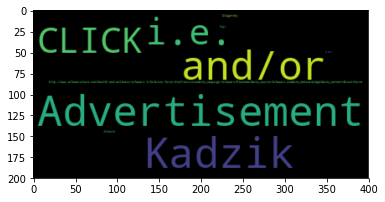

Hot Word in Real News Content


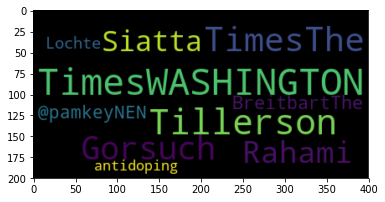

In [0]:
# fake_hhotword = find_hotword(fake_hkw,real_hkw,10)
# real_hhotword = find_hotword(real_hkw,fake_hkw,10)

fake_chotword = find_hotword(fake_ckw,real_ckw,10)
real_chotword = find_hotword(real_ckw,fake_ckw,10)
# result = dict()

print(fake_chotword)
# show_hotword("Hot Word in Fake News Headline", fake_hhotword)
show_hotword("Hot Word in Fake News Content", fake_chotword)
# show_hotword("Hot Word in Real News Headline",real_hhotword)
show_hotword("Hot Word in Real News Content",real_chotword)

## 3.1 Naive Bayesian classifier

As shown above, we find that the fake news tend to use some uncommon and vague words rather than real news, because their author just make up something and people have low understanding of them. It will not be specific.<br><br>

If we want to know the fake probability of a new which contains a specific word$P(fake|word)$, and based on the Bayesian theory, we can know
$P(fake|word) = \frac{P(word|fake)P(fake)}{P(word)}\tag{1}$<br>
But we need to calculate the probability of fake new given a new <br>
Therefore, we actually need to calculate the probability$P(fake|new)$<br>


and we can get
\begin{align}P(fake|new) 
& =\frac{P(new|fake)P(fake)}{P(new)}\tag{2}
\end{align}<br>

A new consists of a set of words. We denote this set of words as $W$,we can know $P(new)=P(W1,W2,W3...Wn),\{W1,W2,W3...Wn\}\in W$<br>

Hence, the formula (1) can be transform to 
\begin{align}P(fake|new) & = \frac{P(W1,W2,W3...Wn|fake)*P(fake)}{P(W1,W2,W3...Wn)} \\
& =\frac{P(W1,W2,W3...Wn|fake)P(fake)}{P(W1,W2,W3...Wn|fake)P(fake)+P(W1,W2,W3...Wn|real)P(real)}\tag{3}
\end{align}

However, there are so much words in a new, even though we have filtered the pronoun and the word of which lemma length is less than 4 letters, and some of them may be never merged in our training dataset. For convenience, we just consider words of which proportion is more than 50% in either fake news or real news

In [0]:
# input: token list and category = {fake,real}
# output: a dictionary of which key is word and value is the number of mail containing that word
def count_word(token,category):
  result = dict()
  if category == "fake":
    wordset = fake_ckw
  else:
    wordset = real_ckw
  for word in wordset:
    for mail in token:
      if word in mail:
        if word in result:
          result[word]+=1
        else:
          result[word]=1
  return sort_dict(result)

In [0]:
# optimize
# input: token list and category = {fake,real}
# output: a dictionary of which key is word and value is the number of mail containing that word
def count_word(token,category):
  result = dict()
  if category == "fake":
    wordset = fake_ckw
  else:
    wordset = real_ckw
  for mail in token:
    temp = dict()
    for word in mail:
      if word in temp:
        continue
      temp[word]=1
      if word in result:
        result[word]+=1
      else:
        result[word]=1
  return sort_dict(result)

In [0]:
# input: a table contain headers and a tokenize array
# output: a table appended a colun of fake probability 
def Naive_Bayesian(news,news_content):
  real = real_news
  fake = fake_news

  real = choose_from_top(real,sampling_num)
  fake = choose_from_top(fake,sampling_num)

  real_num = len(real_content_token)
  fake_num = len(fake_content_token)
#   fake_num=len([j for i in fake_content_token for j in i])
#   real_num=len([j for i in real_content_token for j in i])
  all_num = real_num + fake_num

  fake_scale = fake_num/all_num
  real_scale = real_num/all_num

  # all_cwc = fake_cwc + real_cwc

  fake_wc = count_word(fake_content_token,"fake")
  real_wc = count_word(real_content_token,"real")
#   fake_wc = fake_ckw
#   real_wc = real_ckw
  pro_col = np.array([["NB_fake_probability"]])
  for row in news_content:
    pro = 1
    Pf = 1000*fake_num
    Pr = 1000*real_num
    for word in row:
  #     print(word)
        word_tff = word_tfr = 0
        if word in fake_wc:
          word_tff = fake_wc[word]
        if word in real_wc:
          word_tfr = real_wc[word]
        p_w_f = word_tff/fake_num
        p_w_r = word_tfr/real_num
        if p_w_f <=.5 and p_w_r<=.5: #if a word with low frequency in both side, we define it as a new word
          continue
        Pf*= p_w_f
        Pr*= p_w_r
#         print(word)        
  #       Pr/=(word_tff/fake_cwc *fake_scale + word_tfr/real_cwc*real_scale)
#         print("{0:.12f}->{1:.12f}".format(p_w_f,p_w_r))
#     print("Pf Pr:{0:.12f}->{1:.12f}".format(Pf,Pr))
    pro = Pr/(Pr+Pf)
    pro_col=np.append(pro_col,np.array([[pro]]),axis=0)
#     print(pro_col)
  news = np.concatenate((news,pro_col),axis=1)
  return news

In [0]:
# build testing data
test = sampling(all_data,sampling_num,'negative')
test_token=tokenize(test,"all")

In [0]:
# input: a dataset including headers and its last column is prediction probability and a threshold 
# output: a dataset filtered the probability lower than {threshold}
def get_score(dataset,threshold):
    score = np.array([[0,0],[0,0]])
    for row in dataset[1:]:
      pro=float(row[-1])
      if pro>threshold: # transform to binary
        pre = 1
      else:
        pre = 0
      i = int(float(row[-2]))
      score[i][pre]=float(score[i][pre]) + 1
    return score
  
def show_score(score):
  score_table = np.concatenate((np.array([["Ture","False"]]),score),axis=0)
  score_table = np.concatenate((np.array([[""],["Positive"],["Negative"]]),score_table),axis=1)
  acc = int(score[1][0])+int(score[0][1])
  acc /= float(int(score[0][0])+int(score[1][1])+acc)
  print("Accuracy: {}".format(1-acc))
  return show_table(score_table)


In [0]:
# Testing
test_pro=Naive_Bayesian(test,test_token)
show_table(test_pro)

,title,text,label,NB_fake_probability
0,House Republicans Fret About Winning Their Hea...,WASHINGTON — Congressional Republicans have...,1,0.9945754943483658
1,Rift Between Officers and Residents as Killing...,"After the bullet shells get counted, the blood...",1,1.0
2,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...","When Walt Disney’s “Bambi” opened in 1942, cri...",1,0.9999999390929898
3,"Among Deaths in 2016, a Heavy Toll in Pop Musi...","Death may be the great equalizer, but it isn’t...",1,0.9999999925306958
4,Kim Jong-un Says North Korea Is Preparing to T...,"SEOUL, South Korea — North Korea’s leader, ...",1,0.9994925127068219
5,"Sick With a Cold, Queen Elizabeth Misses New Y...","LONDON — Queen Elizabeth II, who has been b...",1,0.96020679470206
6,Taiwan’s President Accuses China of Renewed In...,BEIJING — President Tsai of Taiwan sharpl...,1,0.9897761067208078
7,"After ‘The Biggest Loser,’ Their Bodies Fought...","Danny Cahill stood, slightly dazed, in a blizz...",1,0.9999999999994572
8,"First, a Mixtape. Then a Romance. - The New Yo...","Just how is Hillary Kerr, the founder of ...",1,0.9999951556468692
9,Calling on Angels While Enduring the Trials of...,Angels are everywhere in the Muñiz family’s ap...,1,0.9999943009460803


In [0]:
score = get_score(test_pro,0.8)

In [0]:
show_score(score)

Accuracy: 0.7127595242894578


,,Ture,False
0,Positive,1056,1425
1,Negative,0,2480


##4.Conclusion
This project was completely done from scratch. We could apply 3/4lines of code for a model and use that to make the classifier. But as we went to implement it by ourselves, we faced a lot of challenges and difficulties. That's why only Naive Bayesian approach is implemented. The overall accuracy is 71% with the fact that we set it to .8 probability of being fake. So we cannot say this model is very accurate or best performing one. 

Nevertheless during this project we had known how to do a practical project of machine learning and lessons for those "fancy" model takes a lot to implement in real life scenario.

We tried another different approach namely Google's BERT model but which is not in this colab as we were not able to figure out how it can be implemented for task like flagging.

For future implications, we will keep working on this project as the result we got is not satisfactory. We will try to improve this model as well as implement other model too such as SVM, Random Forest and so on.


## 5.Ethical Issue	
In this world of internet and social media, any occurrence, as well as news, spreads within moments. Moreover, there is no way to validate all that surfs over this medium. We can see from the example of US presidential election how fake news and propaganda was used as a weapon against one of the candidates of the election. This fake news also divides the community causes chaos among citizens. In Sri Lanka fake news surfaced over that a Buddhist monk was killed and it started a massive riot among the Buddhists and the Muslims; as a result, hundreds of innocent people died. So it is essential to validate what we read and more importantly people get the chance to see a flag of a news before they share it but the vast quantity of internet media makes it impossible to check it manually for this reason we think our initiative to implement machine learning to detect fake news has a very good ethical implication.

However, there is also the opposite side of our proposed study and implementation. Like other machine learning projects, the accuracy of our study is not 100% due to the fact of complex and sophisticated nature of human storytelling and expression of thought. As a result, it not possible to flag all the fake news as well as it has flagged some real articles as fake which can perplex the readers.
 
This project is a small step to present the truth to the readers, and as machine learning practitioners, we are utterly aware of our limitations, and with all due respect to real news, we will try to further improve the ethical concerns of this project. 
